In [1]:
import pandas as pd
import nltk
from libs.cleaning import *
from libs.preprocess import *
from matplotlib import pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

nltk_download()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Lectura

In [2]:
DATA_PATH = "../data"
csv_names = ["/tweets_neg_clean.csv","/tweets_pos_clean.csv"]#"/tweets_clean.csv",
dfs = list(map(lambda x: pd.read_csv(DATA_PATH + x), csv_names))
tweets = pd.concat(dfs, ignore_index=True)
tweets.head()

,Tweet,sentiment
0,HOY NO COMULGUE :( Eso neta me hace sentir mal...,-1
1,20. Por tus gustos siempre me has caído bien p...,-1
2,QUE LAMENTABLE MI PROVINCIA :( https://t.co/w...,-1
3,"?Papel. ?Tijeras, te gané. ?¡Papel! ?Tijeras, ...",-1
4,La primera ves que me pasa eso y espero que se...,-1


# Limpieza

In [3]:
tweets["RT"] = tweets["Tweet"].apply(lambda x: 1 if x.startswith("RT") else 0)
tweets.head()

,Tweet,sentiment,RT
0,HOY NO COMULGUE :( Eso neta me hace sentir mal...,-1,0
1,20. Por tus gustos siempre me has caído bien p...,-1,0
2,QUE LAMENTABLE MI PROVINCIA :( https://t.co/w...,-1,0
3,"?Papel. ?Tijeras, te gané. ?¡Papel! ?Tijeras, ...",-1,0
4,La primera ves que me pasa eso y espero que se...,-1,0


In [4]:
tweets["Cleaned"] = limpieza_total(tweets["Tweet"])
tweets["Cleaned"] = tweets["Cleaned"].apply(lambda x: lemmatize_text(x))

In [5]:
tweets["len"] = tweets["Cleaned"].apply(lambda x: len(x.split()))

In [6]:
tweets[tweets["RT"]==0][tweets["Cleaned"]==""].shape

(2207, 5)

# Análisis

In [7]:
print("Total de tweets: {:,}".format(len(tweets)))
print("Total de RTs: {:,}".format(tweets["RT"].sum()))
print("Porcentaje de RTs: {:.2f}%".format(tweets["RT"].mean()*100))

Total de tweets: 110,000
Total de RTs: 104
Porcentaje de RTs: 0.09%


In [8]:
# Top 20 palabras más comunes
top_words = pd.Series(count_words(tweets.Cleaned.str.split())).sort_values(ascending=False)
top_words_nort = pd.Series(count_words(tweets[tweets.RT != 1].Cleaned.str.split())).sort_values(ascending=False)

top_words_per = top_words / top_words.sum()
top_words_nort_per = top_words_nort / top_words_nort.sum()

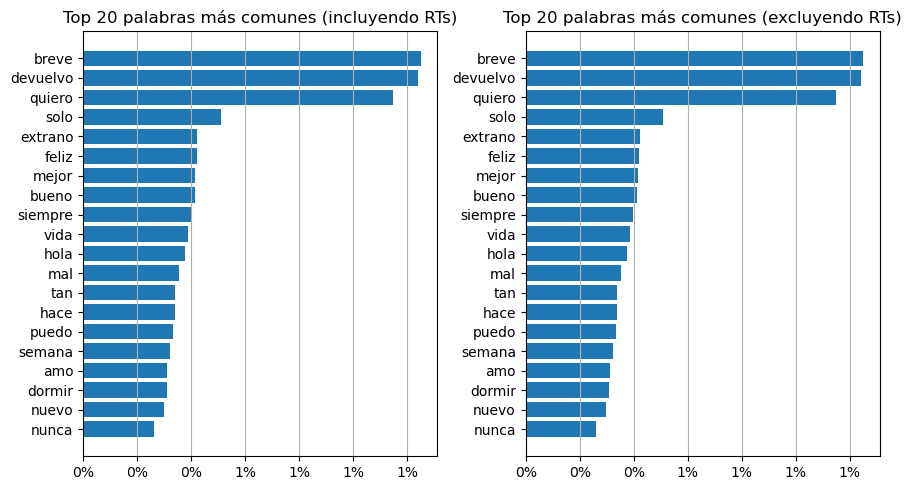

In [9]:
from matplotlib.ticker import FuncFormatter

# Función para formatear los valores como porcentaje
formatter = FuncFormatter(lambda x, pos: f'{x:.0%}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axes[0].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# Invertir el orden de las palabras y los valores en el eje y para la primera gráfica
axes[0].barh(top_words_per.index[:20], top_words_per.values[:20])
axes[0].set_title("Top 20 palabras más comunes (incluyendo RTs)")
axes[0].invert_yaxis()  # Voltear en espejo
axes[0].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje

axes[1].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# Invertir el orden de las palabras y los valores en el eje y para la segunda gráfica
axes[1].barh(top_words_nort_per.index[:20][::-1], top_words_nort_per.values[:20][::-1])
axes[1].set_title("Top 20 palabras más comunes (excluyendo RTs)")
axes[1].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje

plt.tight_layout()
plt.show()

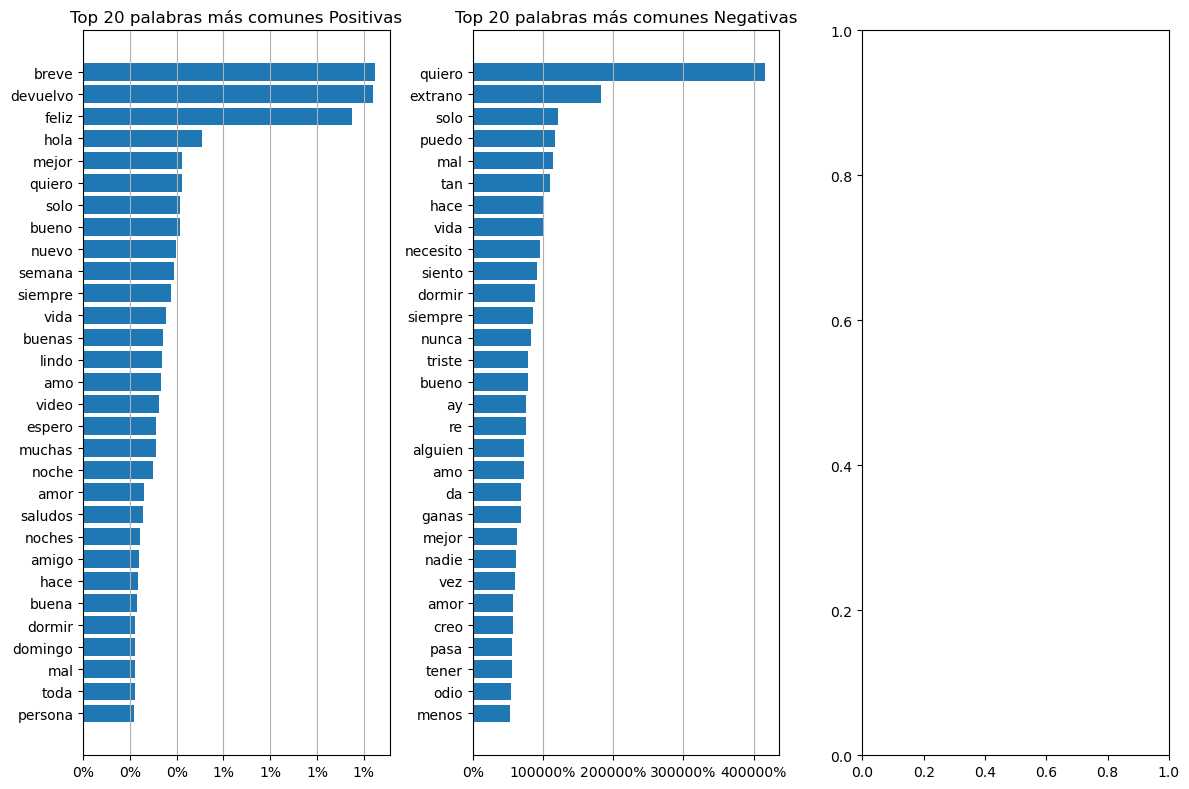

In [10]:
#Top 20 words en cada categoría
top_words_pos = pd.Series(count_words(tweets[tweets["sentiment"]==1].Cleaned.str.split())).sort_values(ascending=False)
top_words_neg = pd.Series(count_words(tweets[tweets["sentiment"]==-1].Cleaned.str.split())).sort_values(ascending=False)
top_words_neu = pd.Series(count_words(tweets[tweets["sentiment"]==0].Cleaned.str.split())).sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

axes[0].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# Invertir el orden de las palabras y los valores en el eje y para la primera gráfica
axes[0].barh(top_words_pos.index[:30], top_words_per.values[:30])
axes[0].set_title("Top 20 palabras más comunes Positivas")
axes[0].invert_yaxis()  # Voltear en espejo
axes[0].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje

axes[1].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# Invertir el orden de las palabras y los valores en el eje y para la segunda gráfica
axes[1].barh(top_words_neg.index[:30][::-1], top_words_neg.values[:30][::-1])
axes[1].set_title("Top 20 palabras más comunes Negativas")
axes[1].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje

# axes[2].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# # Invertir el orden de las palabras y los valores en el eje y para la segunda gráfica
# axes[2].barh(top_words_neu.index[:30][::-1], top_words_neu.values[:30][::-1])
# axes[2].set_title("Top 20 palabras más comunes Neutras")
# axes[2].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje
plt.tight_layout()
plt.show()

In [11]:
tweets = tweets[tweets["RT"] == 0][tweets["Cleaned"]!=""][tweets["len"]>=3].sample(frac=0.40, random_state=42)

In [12]:
tweets["sentiment"].groupby(tweets["sentiment"]).count()

sentiment
-1    14829
 1    14160
Name: sentiment, dtype: int64

# Clustering

## Tokenize

In [13]:
tweets["Token"] = tweets.Cleaned.str.split()

## Train test split

In [14]:
#importamos train test split
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(tweets["Cleaned"], tweets["sentiment"], test_size=0.2, random_state=42)

## Embeddings

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
w2v = TfidfVectorizer(min_df=10)
w2v.fit(X_train)

TfidfVectorizer(min_df=10)

In [18]:
X_train_emb = w2v.transform(X_train)

X_test_emb = w2v.transform(X_test)

In [19]:
#Numero de palabras aprendidas
len(w2v.vocabulary_)

2023

## T-SNE
(Para pre visualizar los datos)

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=2, random_state=42,
             n_iter=2000, perplexity=30, init='random',
               metric='cosine', n_jobs=-1)
# X_train_emb = np.vstack(X_train_emb.to_numpy())
# X_test_emb = np.vstack(X_test_emb.to_numpy())
tsne_cord = tsne.fit_transform(X_train_emb)

## Pre visualización

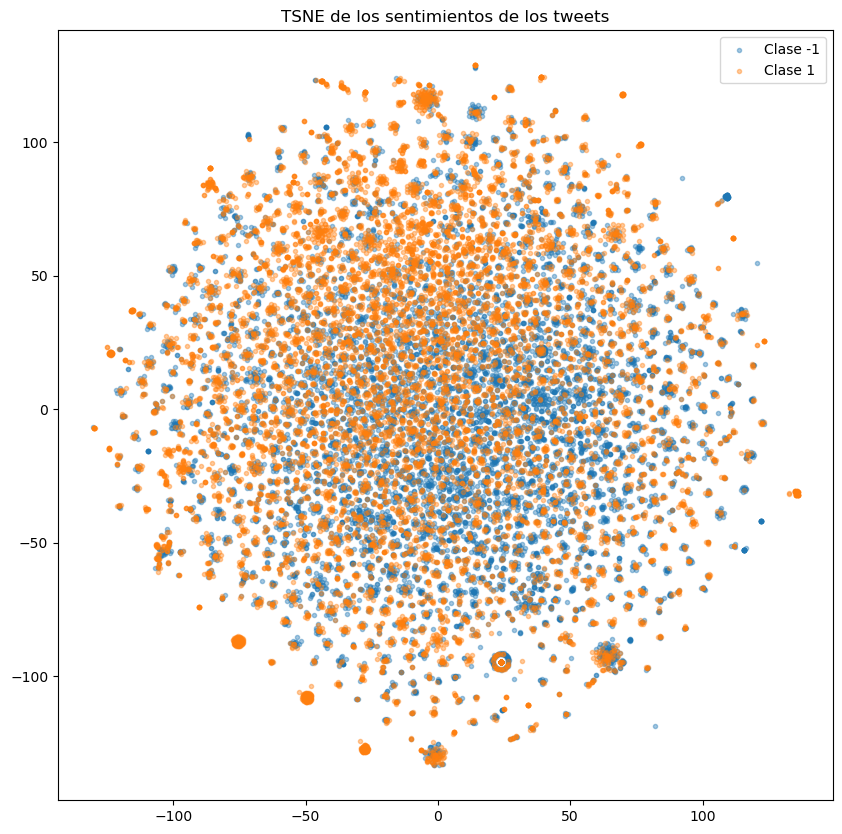

In [22]:
def plot_tsne(tsne_cord, y_train=y_train):
    pre_vis = np.vstack(tsne_cord)
    fig = plt.figure(figsize=(10, 10))
    for clase in np.unique(y_train):
        indices = np.where(y_train == clase)
        plt.scatter(tsne_cord[indices, 0], tsne_cord[indices, 1],
                     label=f'Clase {clase}', marker='.', alpha=0.4)
    plt.title("TSNE de los sentimientos de los tweets")
    plt.legend()
    plt.show()

plot_tsne(tsne_cord=tsne_cord, y_train=y_train)

# Clasificador

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [24]:
svc = SVC()

# SVC

In [25]:
#SVC
param_svc = {
    'C': [0.2, 0.5,0.7]
}
GS_svc = GridSearchCV(svc, param_svc, cv=5, n_jobs=-1)
GS_svc.fit(X_train_emb, y_train)
print(GS_svc.best_params_)
y_pred = GS_svc.predict(X_test_emb)
print("Reporte de prueba")
print(classification_report(y_test, y_pred))
print("Reporte de entrenamiento")
y_pred = GS_svc.predict(X_train_emb)
print(classification_report(y_train, y_pred))

{'C': 0.7}
Reporte de prueba
              precision    recall  f1-score   support

          -1       0.70      0.74      0.72      2947
           1       0.72      0.67      0.69      2851

    accuracy                           0.71      5798
   macro avg       0.71      0.71      0.71      5798
weighted avg       0.71      0.71      0.71      5798

Reporte de entrenamiento
              precision    recall  f1-score   support

          -1       0.85      0.88      0.87     11882
           1       0.87      0.84      0.85     11309

    accuracy                           0.86     23191
   macro avg       0.86      0.86      0.86     23191
weighted avg       0.86      0.86      0.86     23191



In [28]:
print(GS_svc.best_estimator_.get_params())

{'C': 0.7, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
